In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

# Parameters
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Encoder
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(CHANNELS, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

# Autoencoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Callbacks
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Train the autoencoder
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

# Save the final models
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

# Reconstruct using the autoencoder
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions = autoencoder.predict(example_images)

# Display results
print("Example real clothing items")
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.axis("off")

print("Reconstructions")
for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()

# Embed using the encoder
embeddings = encoder.predict(example_images)
print("Embeddings (first 10):")
print(embeddings[:10])


In [4]:
# Encoder
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(CHANNELS, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Autoencoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Train the autoencoder
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test)
)


Epoch 1/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 112s 182ms/step - loss: 0.3667 - val_loss: 0.2666
Epoch 2/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 126s 209ms/step - loss: 0.2613 - val_loss: 0.2584
Epoch 3/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 119s 199ms/step - loss: 0.2564 - val_loss: 0.2559


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


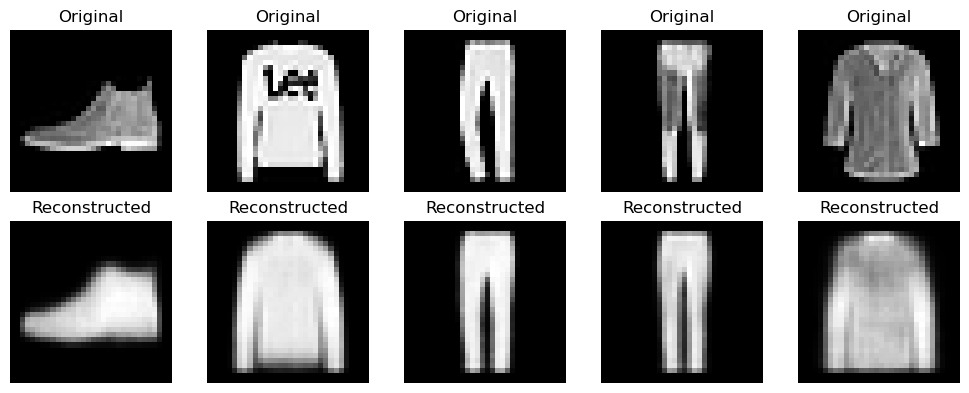

In [6]:
# Selecting 5 test images
selected_images = x_test[:5]

# Reconstructing using the autoencoder
reconstructed_images = autoencoder.predict(selected_images)

# Visualizing original and reconstructed images
plt.figure(figsize=(10, 4))

# Original Images
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

# Reconstructed Images
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i].squeeze(), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Conclusion:
# The above images clearly show that:
# 1) For the first shoes image, the original has more accurate shape of shoes than the reconstructed one.
# 2) For the t-shirt image, both image has similar shape of t-shirt but the reconstructed lacks the tag or the logo in center.
# 3) The 3rd image seems more identical in shape but one is like folded and other is straight.
# 4) The 4th image seems much more similar. Just the reconstructed lacks some tags.
# 5) The fifth one origin seems the most perfect one. But its reconstructed is the worst one. The reconstructed one shape has changed entirely.